In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(16,10)})
plt.style.use('seaborn-whitegrid')

In [3]:
year = '11'

In [87]:
data = pd.read_csv(f'../outputs/{year}/out{year}.csv', index_col='Unnamed: 0')
triggers = pd.read_csv(f'../outputs/{year}/triggers{year}.csv', index_col='label')
reg_eff = pd.read_csv(f'../outputs/model/outmodel.csv', index_col='Unnamed: 0')

In [94]:
data.head()

,Nsig,dNsig,Emean,dEmax,dEmin,lum,err
525.0,810.42,29.27,523.58,0.0,-0.0,469.339,1.10750
537.5,885.56,30.26,537.41,0.0,-0.0,554.231,1.22073
550.0,379.98,20.27,548.44,0.0,-0.0,493.501,1.17935
562.5,385.34,20.18,562.13,-0.0,0.0,549.094,1.27306
575.0,158.11,13.23,575.31,0.0,-0.0,493.710,1.23988


Rewrite luminosities

In [89]:
lum = pd.read_csv(f'../inputs/{year}/lum', index_col='label')

In [90]:
data.drop('lum', axis=1, inplace=True)

In [91]:
lum.head()

,lum,err
label,,
525.0,469.339,1.10750
550.0,493.501,1.17935
575.0,493.710,1.23988
600.0,557.452,1.38228
625.0,411.009,1.22550


In [93]:
data = data.join(lum)

Triggers

In [95]:
triggers.head()

,TF,CF,TC,eTF,eCF,eff,TrigEff,vTF,vCF,TrigErr
label,,,,,,,,,,
525.0,318.0,384.0,152.0,0.28,0.32,0.52,0.52,0.02,0.02,0.02
537.5,508.0,20.0,393.0,0.95,0.44,0.97,0.97,0.01,0.02,0.01
550.0,235.0,62.0,103.0,0.62,0.31,0.74,0.74,0.04,0.02,0.03
562.5,237.0,9.0,168.0,0.94,0.42,0.97,0.97,0.02,0.02,0.01
575.0,97.0,27.0,45.0,0.62,0.32,0.74,0.74,0.06,0.04,0.04


In [96]:
reg_eff.head()

,Nsig,dNsig,lum,dEmin,dEmax,Emean
550.0,1800.36,44.01,7163,0.0,0.0,550.0
562.5,1573.35,41.42,6306,0.0,0.0,562.5
575.0,1374.38,38.87,5516,0.0,0.0,575.0
587.5,1311.21,37.58,5116,0.0,0.0,587.5
600.0,1134.09,35.69,4606,0.0,0.0,600.0


Get N/L

In [97]:
data['CSvis'] = data['Nsig']/data['lum']
data['dCSvis'] = data['dNsig']/data['lum']

Trigger join

In [98]:
data = data.join(triggers[['TrigEff', 'TrigErr']], how='left')

In [99]:
data = data.drop(['Nsig', 'dNsig', 'lum'], axis=1)

Get Reg_eff

In [100]:
reg_eff['RegEff'] = reg_eff['Nsig']/reg_eff['lum']
reg_eff['RegErr'] = reg_eff['dNsig']/reg_eff['lum']
reg_eff.drop(['dEmax', 'dEmin', 'lum', 'Nsig', 'dNsig'], axis=1, inplace=True)

Reg eff join

In [101]:
data['RegEff'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegEff), axis=1)
data['RegErr'] = data.apply(lambda x: np.interp(x['Emean'], reg_eff.Emean, reg_eff.RegErr), axis=1)

Recalc cross section

In [102]:
data['CS'] = data['CSvis']/data['TrigEff']/data['RegEff'];
data['dCS'] = data['CS']*np.sqrt( np.square( data['dCSvis']/data['CSvis'] ) + 
                                np.square( data['TrigErr']/data['TrigEff'] ) + 
                                np.square( data['RegErr']/data['RegEff'] ))

In [103]:
data.drop(['CSvis', 'dCSvis', 'TrigEff', 'TrigErr', 'RegEff', 'RegErr'], axis=1, inplace=True)

In [104]:
data.to_csv('../outputs/'+year+'/result_new.csv')

## Draw cross sections

In [4]:
cs11 = pd.read_csv('../outputs/11/result_new.csv', index_col=['Unnamed: 0'])
cs12 = pd.read_csv('../outputs/12/result_new.csv', index_col=['Unnamed: 0'])
cs17 = pd.read_csv('../outputs/17/result_new.csv', index_col=['Unnamed: 0'])
cs19 = pd.read_csv('../outputs/19/result_new.csv', index_col=['Unnamed: 0'])

In [5]:
radcor = pd.read_csv('rad_cors.dat', delimiter='\t', names=['energy', 'radcor'], index_col=['energy'])

In [6]:
cs19.tail()

,dEmin,dEmax,Emean,err,CS,dCS
950.0,0.0,0.0,950.15,3.89619,0.046547,0.015929
955.0,0.0,0.0,956.05,3.14302,0.068612,0.026709
962.5,0.0,0.0,962.82,3.99610,0.077600,0.016723
975.0,0.0,0.0,976.21,5.68205,0.005780,0.003647
987.5,0.0,0.0,987.80,4.35670,0.086559,0.017083


In [7]:
radcor.head()

,radcor
energy,
525.0,0.863528
540.0,0.861685
550.0,0.867511
562.5,0.874765
575.0,0.881186


In [8]:
cs11['rad'] = np.interp(cs11.Emean, radcor.index, radcor.radcor)
cs12['rad'] = np.interp(cs12.Emean, radcor.index, radcor.radcor)
cs17['rad'] = np.interp(cs17.Emean, radcor.index, radcor.radcor)
cs19['rad'] = np.interp(cs19.Emean, radcor.index, radcor.radcor)

In [9]:
def born(data):
    data['born'] = data.CS/data.rad
    data['born_err'] = data.dCS/data.rad

In [10]:
born(cs11)
born(cs12)
born(cs17)
born(cs19)

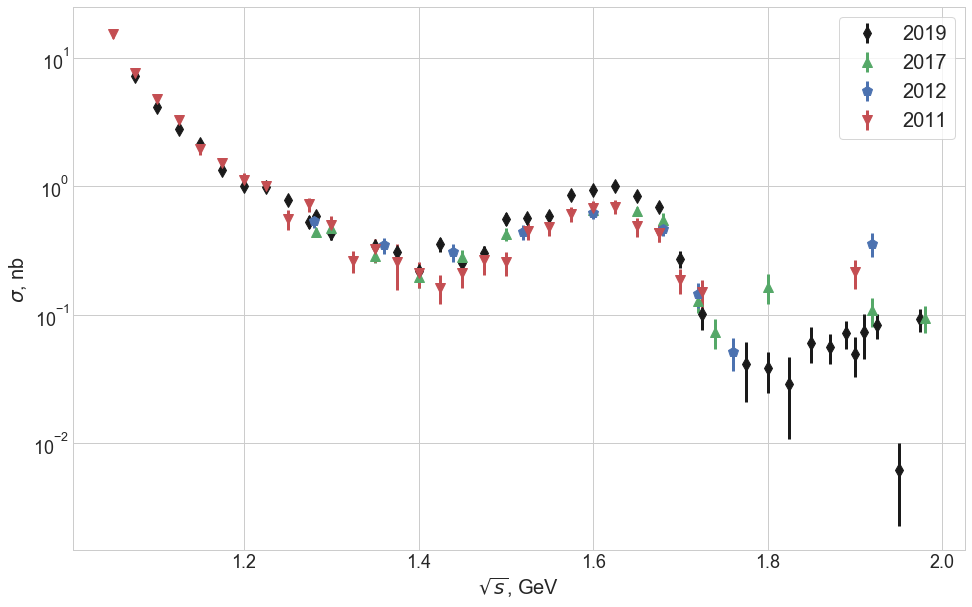

In [120]:
plt.errorbar(cs19.index*2e-3, cs19.born, yerr=cs19.born_err, fmt='kd', elinewidth=3, ms=10, label='2019')
plt.errorbar(cs17.index*2e-3, cs17.born, yerr=cs17.born_err, fmt='g^', elinewidth=3, ms=10, label='2017')
plt.errorbar(cs12.index*2e-3, cs12.born, yerr=cs12.born_err, fmt='bp', elinewidth=3, ms=10, label='2012')
plt.errorbar(cs11.index*2e-3, cs11.born, yerr=cs11.born_err, fmt='rv', elinewidth=3, ms=10, label='2011')
plt.yscale('log')
plt.xlabel('$\sqrt{s}$, GeV', fontsize=20)
plt.ylabel('$\sigma$, nb', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=18)
ax.legend(fontsize=20, frameon=True)
#plt.savefig('cs.svg')